# Proyecto Módulo 2: Implementación de un modelo de deep learning - A00829937

| Alumno                              | Matrícula  |
|-------------------------------------|------------|
| Axel Amós Hernández Cárdenas        | A00829837  |


<br/>

# Introducción

La pandemia de COVID-19, que comenzó en 2020, trajo consigo cambios significativos en la vida diaria a nivel mundial. Una de las medidas de protección más generalizadas fue el uso de mascarillas faciales en espacios públicos, convirtiéndose en una norma en muchos países para reducir la probabilidad de transmisión del virus. Esta medida, aunque efectiva para la salud y bienestar público, planteó un gran desafío para las tecnologías que utilizaban el reconocimiento facial, como los dispositivos personales o, en algunos casos, los sistemas de seguridad.

Antes de la pandemia, los sistemas de reconocimiento facial estaban mayormente diseñados para funcionar con rostros completamente visibles. Con la inclusión de mascarillas que cubren la mitad inferior del rostro, estos sistemas se vieron afectados ya que perdieron acceso a información visual, como la forma de la boca, la barbilla o incluso parte de la nariz. Lo anterior, redujo drásticamente la precisión de las tecnologías de identificación, como Face-ID, revelando la necesidad de adaptar los modelos de visión computacional y machine learning para solucionar este reto.

Este portafolio aborda esta problemática mediante la construcción de un modelo de red neuronal convolucional (CNN) capaz de detectar si una persona lleva o no una mascarilla en una imagen. La idea es recrear el esfuerzo realizado durante la pandemia para entrenar modelos que permitieran reconocer correctamente a una persona, incluso si ésta usaba una mascarilla, lo cual permitió mejorar las tecnologías de reconocimiento facial en muchos dispositivos alrededor del mundo.

### Objetivo del Notebook

El objetivo de este notebook es construir un modelo de clasificación de imagenes mediante una red neuronal convolucional (CNN) que distinga entre personas con y sin mascarilla. Para lograr esto, se utilizará el **Face Mask Dataset** disponible en *Kaggle*, que ofrece una colección variada de imagenes en ambas categorías, permitiendo entrenar el modelo en un amplio rango de ejemplos. Se espera que, tras el entrenamiento, el modelo sea capaz de hacer predicciones precisas no solo en las imagenes de entrenamiento y prueba, sino también en imagenes nuevas y no vistas.

Como parte del objetivo final, el modelo será exportado e implementado en una aplicación para iOS, donde será evaluado en un ambiente real para comprobar su eficacia en el reconocimiento de personas con o sin mascarilla.

### Obtención del Dataset

Como se mencionó anteriormente, el conjunto de datos se obtuvo a través de la plataforma Kaggle (Gurav, 2020). Este dataset está compuesto por un total de 7,553 imagenes en color (3 canales RGB), que representan a personas en dos categorías: con mascarilla y sin mascarilla. La estructura del dataset facilita el uso en tareas de clasificación binaria, ya que las imagenes están organizadas en carpetas separadas para cada clase. (https://www.kaggle.com/datasets/omkargurav/face-mask-dataset?resource=download)

### Análisis del Dataset

Analizando el dataset se tiene lo siguiente:

* **Cantidad total de imagenes:** 7,553 imagenes en color, divididas en dos carpetas:
	* **with_mask**: 3,725 imagenes de personas con mascarilla.
	* **without_mask**: 3,828 imagenes de personas sin mascarilla.

* **Clasificación:** 
    * Las imagenes están organizadas en dos carpetas según la clase, pero no cuentan con etiquetas explícitas. Estas etiquetas se generarán en la fase de limpieza para identificar cada imagen como `con mascarilla` o `sin mascarilla`.

* **Dimensiones y color:**
	* Las imagenes están en formato RGB (3 canales de color).
	* Las dimensiones originales de las imagenes varían, por lo que se deberán redimensionar en la limpieza de datos.

* **Tipo de datos:**
	* Los valores de los píxeles son enteros (int8) que van de 0 a 255, donde 0 representa el negro y 255 representa el blanco en cada canal de color.

* **Integridad de los datos:**
	* No se identificaron valores nulos ni inconsistencias en las imagenes.



### Declaración de Librerías

En esta sección se muestra la declaración de librerías utilizadas en el notebook.

In [1]:
# Declaración de Librerias
import os
import re
import keras
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### Carga y Análisis de las Imágenes

Para comenzar, se especificaron las rutas de los folders que contienen las imagenes, asignándolas a las variables `path_con` y `path_sin`. La variable `path_con` contiene la ruta hacia las imagenes de personas con mascarilla, mientras que `path_sin` contiene la ruta hacia las imagenes de personas sin mascarilla. Después, se utilizaron estas rutas para crear dos listas, `con_cubre` y `sin_cubre`, que almacenan las rutas completas de cada imagen. Estas listas permiten el acceso a las imagenes de cada clase. Finalmente, se realizó un conteo de las imagenes en cada categoría para verificar la cantidad de imagenes para cada clase.

In [2]:
# 1. Path de las imagenes
path_con = '/Users/axelamoshernandezcardenas/Desktop/IAClase/IA2/Itzel/3. Portafolio/with_mask'
path_sin = '/Users/axelamoshernandezcardenas/Desktop/IAClase/IA2/Itzel/3. Portafolio/without_mask'

# 2. Procesar los paths a las imagenes en un arreglo
con_cubre = [os.path.join(path_con, img) for img in os.listdir(path_con)]
sin_cubre = [os.path.join(path_sin, img) for img in os.listdir(path_sin)]
#print(con_cubre)

# 3. Exploración de imagenes
print("====== Número de imagenes ======")
print(f'Con mascarilla --> {len(con_cubre)}')
print(f'Sin mascarilla --> {len(sin_cubre)}')

====== Número de imagenes ======
Con mascarilla --> 3725
Sin mascarilla --> 3828


### Visualización de Imágenes (Sin Procesamientos)


Después de realizar la carga de los paths de rutas a las imagenes, se creó una función para la visualización de imagenes de manera aleatoria para ambos conjuntos (`con_cubre` y `sin_cubre`). Esta función despliega tres imagenes seleccionadas al azar de cada arreglo, lo cual es útil para determinar las técnicas necesarias de normalización y redimensionamiento que se deberán llevar a cabo en la limpieza de datos.

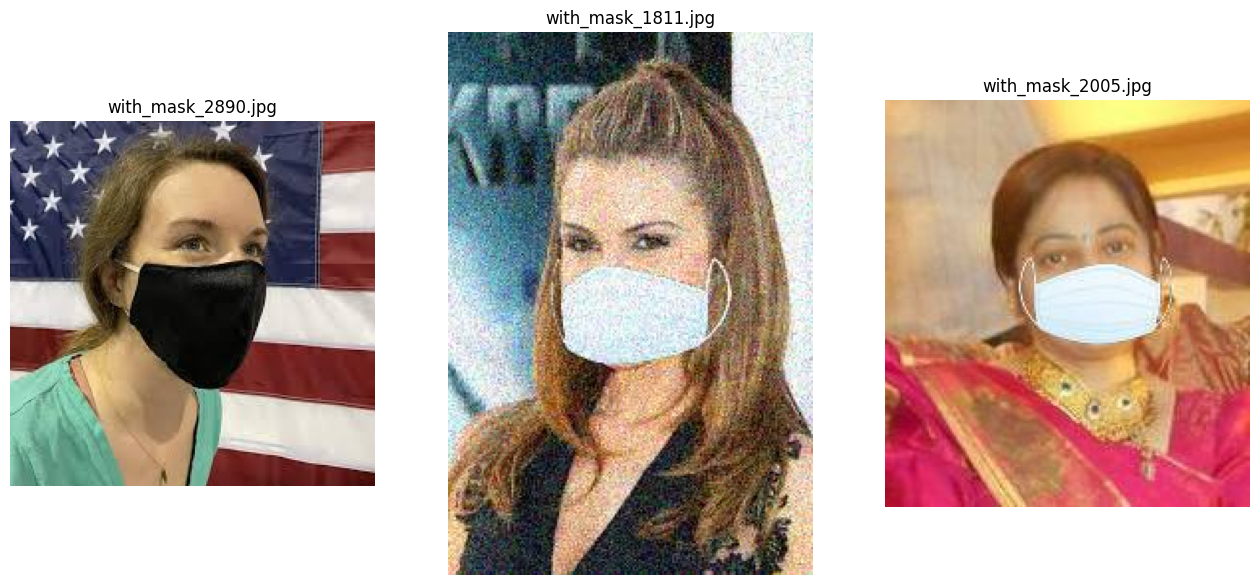

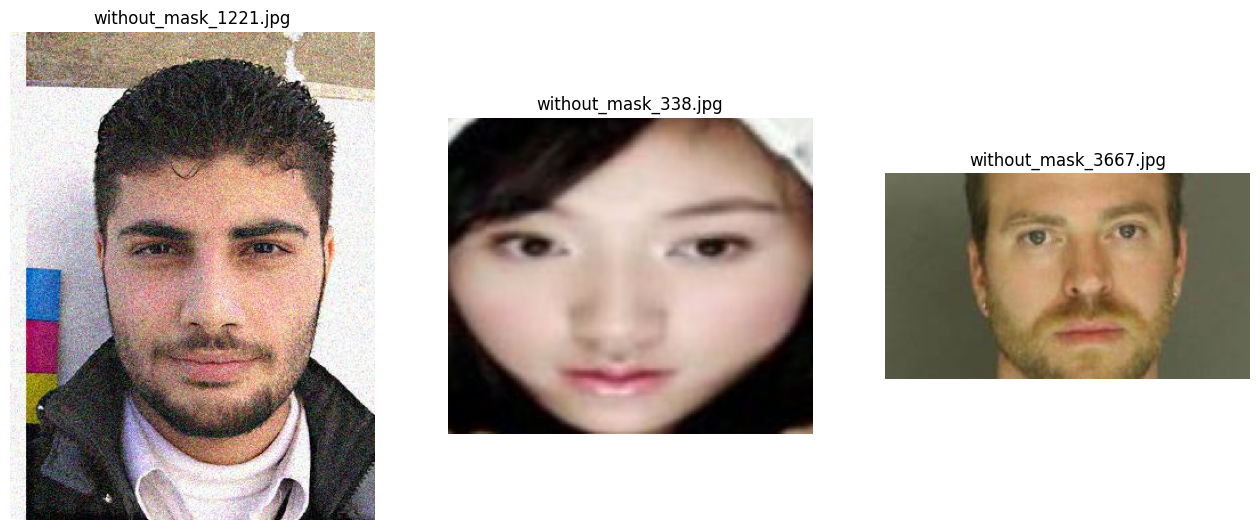

In [31]:
# 4. Función para visualizar las imagenes
# Parámetros: (set de imagenes , número de imagenes)
def plotImages(imgSet, n):
    plt.figure(figsize=(16, 16))
    
    selected_images = random.sample(imgSet, n) #  N imagenes random
    
    for i, img_path in enumerate(selected_images):
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(re.sub(r'^.*/', '', img_path)) # Para quitar el path a la imagen y dejar solo el nombre
        plt.axis('off')

plotImages(con_cubre, 3)
plotImages(sin_cubre, 3)

plt.show()

## Limpieza del Dataset


### Creación de Label, Resizing de Imágenes y Normalización

Como se había mencionado en la sección 2.0.3, la limpieza de datos en términos de valores faltantes no es requerida, sin embargo, es necesario realizar cuatro modificaciones a los datos:

* Crear las etiquetas para cada clase: asignar `1` a las imagenes de personas con mascarilla y `0` a las imagenes de personas sin mascarilla.
* Redimensionar las imagenes a un tamaño de **244x244 píxeles**.
* Normalizar las imagenes al rango [0, 1] para evitar problemas de vanishing gradient y facilitar el proceso de entrenamiento en la CNN al reducir la varianza y rango de los datos.
* Ligar las imagenes de `sin_cubre_resized` y `con_cubre_resized` a su respectivo label.

In [ ]:
# 5. Función para cargar, redimensionar y normalizar las imagenes
# Parámetros (path a la imagen)
def resize_and_norm(img_path):

    # Se lee la imagen y se carga en el formato RGB
    img = Image.open(img_path).convert("RGB")  
    
    # Redimensionar la imagen a 224x224
    img = img.resize((224, 224)) 
    
    # Normalizar la imagen a [0, 1]
    img = np.array(img) / 255.0 

    return img

# 6. Preprocesamiento de Imágenes (Normalización y Resizing)
con_cubre_resized = np.array([resize_and_norm(img) for img in con_cubre])
sin_cubre_resized = np.array([resize_and_norm(img) for img in sin_cubre])
print(f'Nuevo Tamaño de Imágen CON --> {con_cubre_resized[0].shape}')
print(f'Nuevo Tamaño de Imágen SIN --> {con_cubre_resized[0].shape}')

# 7. Creación de Label para Clasificación (deben ser la misma cantidad que imagenes de cada set)
cc_label = [1] * len(con_cubre_resized) # 1 si tiene cubrebocas
sc_label = [0] * len(sin_cubre_resized) # 0 si no
print(f'Número de Labels CON -> {len(cc_label)}')
print(f'Número de Labels SIN -> {len(sc_label)}')

/Users/axelamoshernandezcardenas/Desktop/IAClase/myenv/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Nuevo Tamaño de Imágen CON --> (224, 224, 3)
Nuevo Tamaño de Imágen SIN --> (224, 224, 3)
Número de Labels CON -> 3725
Número de Labels SIN -> 3828


### Visualización de Imágenes (Con Procesamientos)

Después de realizar el resizing, se definió otra funcion similar a la de la seccion 2.0.6 para la visualización de imagenes de manera aleatoria de los nuevos conjutnos creados. De igual manera, la función despliega tres imagenes seleccionadas al azar de cada arreglo.

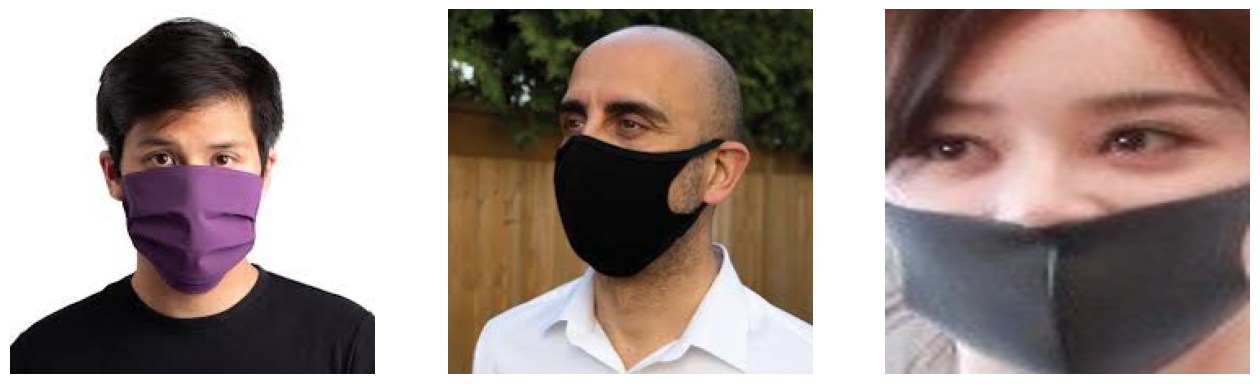

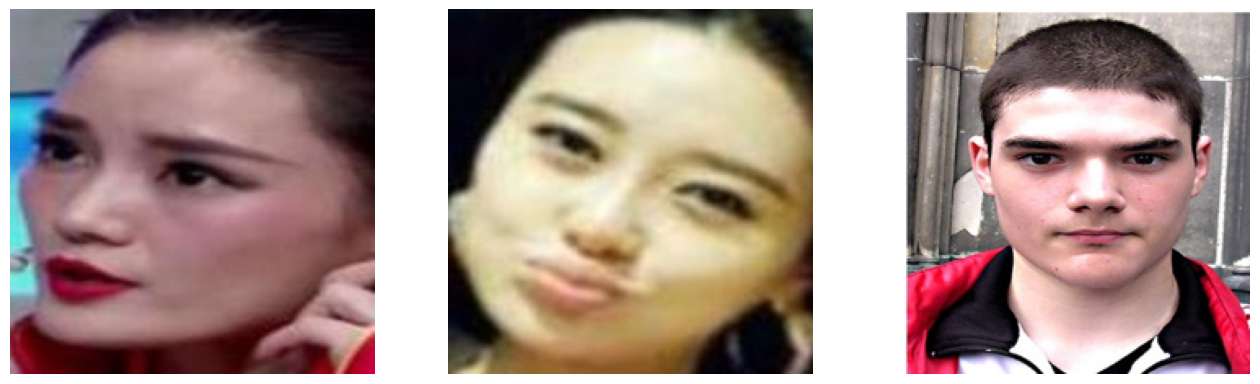

In [50]:
# 8. Función para visualizar las imagenes
# Parámetros: (set de imagenes , número de imagenes)
def plotImages(imgSet, n):
    
    plt.figure(figsize=(16, 16))
    selected_images = random.sample(imgSet, n) #  N imagenes random
    
    for i, img in enumerate(selected_images):
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')

plotImages(list(con_cubre_resized), 3)
plotImages(list(sin_cubre_resized), 3)

# Desarrollo del Modelo de Deep Learning

## Merge del Dataset y División en Conjuntos de Entrenamiento y Prueba

Una vez finalizado el preprocesamiento de las imagenes, se combinan todas las imagenes de ambas clases en una única lista, `imagenes`, a la que se le asigna su respectivo label:

* **Label '1':** Imagen con mascarilla
* **Label '0':** Imagen sin mascarilla

Realizado lo anterior, éstas se mezclan aleatoriamente asegurando que cada imagen mantenga su correspondencia con su etiqueta. Esto ayuda a lograr una distribución equilibrada entre ambas clases en el conjunto de datos. Finalmente, se utiliza `train_test_split` para dividir el conjunto en un 80% para entrenamiento y un 20% para prueba.

In [ ]:
#9. Juntar las imagenes y labels para su posterior split para el modelo. Después, mezclarlas.
imagenes = np.concatenate([con_cubre_resized, sin_cubre_resized]) # Concatenar imagenes en una sola lista
labels = np.array(cc_label + sc_label) # Crear la lista de labels
imagenes, labels = shuffle(imagenes, labels, random_state=42)
#print(labels)
#print(data[0])

#10. Split del Dataset
X_train, X_test, y_train, y_test = train_test_split(imagenes, labels, test_size=0.2, random_state=42)

In [7]:
#11. Prints de análisis de los conjuntos creados
print("====== INSTANCIAS Y FILAS ======")
print('Total de Instancias y (Filas x Columnas) en x_train -->', X_train.shape)
print('Total de Instancias en y_train -->', y_train.shape)
print('Total de Instancias y (Filas x Columnas) en x_test -->', X_test.shape)
print('Total de Instancias en y_test: -->', y_test.shape)
print("====== TIPOS DE DATOS ======")
print(f'Tipo de datos de x_train: {X_train.dtype} y x_test: {X_test.dtype}')
print(f'Tipo de datos de y_train: {y_train.dtype} y y_test: {y_test.dtype}')

====== INSTANCIAS Y FILAS ======
Total de Instancias y (Filas x Columnas) en x_train --> (6042, 224, 224, 3)
Total de Instancias en y_train --> (6042,)
Total de Instancias y (Filas x Columnas) en x_test --> (1511, 224, 224, 3)
Total de Instancias en y_test: --> (1511,)
====== TIPOS DE DATOS ======
Tipo de datos de x_train: float64 y x_test: float64
Tipo de datos de y_train: int64 y y_test: int64


## Encontrando la Mejor Configuración para la CNN

Como se mencionó al inicio, la arquitectura seleccionada es una CNN compuesta por tres capas convolucionales (cada una seguida de una capa de max pooling y dropout) y una capa densa al final, antes de la capa de salida. 

Para evaluar el impacto de diferentes configuraciones de hiperparámetros, se establecieron cuatro combinaciones específicas las cuales se guardaron en una variable por nombre de `configuraciones`. Cada configuración varía en el número de filtros en cada capa convolucional, el tamaño de las unidades en la capa densa final y las tasas de dropout. Esto permite encontrar un modelo que pueda maximizar los resultados de los métricos y pueda evitar el overfitting.

### Descripción por capas y Justificación de Hiperparámetros

**Capas Convolucionales**: Cada configuración incluye tres capas convolucionales con diferentes cantidades de filtros 32, 64 y 128. Los filtros iniciales capturan características de bajo nivel, mientras que los más profundos capturan patrones más complejos. Por lo anterior, se pretende utilizar una mayor cantidad de filtros en la segunda y tercera capa de la red.

**Max Pooling**: Después de cada capa convolucional, se aplica MaxPooling2D para reducir las dimensiones espaciales, permitiendo que el modelo mantenga las características más importantes y reduzca la cantidad de parámetros. Para todas las configuraciones, se mantuvo un valor de Max Pooling de una ventana 2x2.

**Dropout**: Despues de cada MaxPooling y de la capa densa, se aplicó un valor de dropout. Las tasas de dropout varían en cada configuración para las cuatro declaraciones (dropout_1, dropout_2, dropout_3, dropout_4), cada una con un valor ligeramente mas alto que el anterior. Esta regularización ayudará a disminuir el overfitting que pueda generarse.

**Dense Layer**: La capa densa antes de la salida se utiliza para juntar las características aprendidas. La cantidad de unidades en esta capa (d_units) varía entre 64 y 128 en cada configuración.

**Capa de Salida**: La última capa es una capa de una sola neurona con activación sigmoid, que convierte la salida en un valor entre 0 y 1, lo cual es ideal para este problema de clasificación binaria.

### Optimizadores, Función de Costo y Callbacks

Para todas las configuraciones se utiliza:

**Optimizador:** *Adam*, ya que es computacionalmente eficiente y tiene una baja demanda de memoria en comparación con otros métodos de optimización. Esto es importante cuando se entrena una CNN, que puede tener una gran cantidad de parámetros. Además, al trabajar sin GPU, Adam permite una convergencia rápida sin requerir un tiempo de cómputo excesivo. (Keras, 2022)

**Función de Costo:** *Binary_crossentropy*, ya que es el estándar para los problemas de clasificación binaria.

**Callbacks:** Para mejorar la eficiencia del entrenamiento, se implementó el callback de *Early_stopping*, el cual monitorea la pérdida en la validación (**val_loss**) y detiene el entrenamiento si no hay mejora en los siguientes 3 epochs.

In [8]:
#12. Cuatro configuraciones distintas para la CNN
configuraciones = [
    {'filtros_cn1': 32, 'filtros_cn2': 64, 'filtros_cn3': 64, 'd_units': 64,
     'dropout_1': 0.2, 'dropout_2': 0.2, 'dropout_3': 0.2, 'dropout_4': 0.3},

    {'filtros_cn1': 32, 'filtros_cn2': 128, 'filtros_cn3': 64, 'd_units': 128,
     'dropout_1': 0.25, 'dropout_2': 0.25, 'dropout_3': 0.3, 'dropout_4': 0.4},

    {'filtros_cn1': 64, 'filtros_cn2': 64, 'filtros_cn3': 128, 'd_units': 64,
     'dropout_1': 0.3, 'dropout_2': 0.2, 'dropout_3': 0.3, 'dropout_4': 0.3},

    {'filtros_cn1': 64, 'filtros_cn2': 128, 'filtros_cn3': 128, 'd_units': 128,
     'dropout_1': 0.2, 'dropout_2': 0.3, 'dropout_3': 0.2, 'dropout_4': 0.4}
]

#13. Configuración del Callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#14. Variables para almacenar los mejores hiperparámetros, modelo y accuracy.
best_accuracy = 0
best_model = None
best_hiper = {}
best_history = None

#15. For para iterar sobre las configuraciones establecidas para cada CNN
for config in configuraciones:
    model = Sequential([
        
        # Capa de entrada del modelo con el tamaño de entrada de 224x224 pixeles y 3 canales (RGB)
        layers.InputLayer(shape=(224, 224, 3)),

        # Primera capa convolucional
        layers.Conv2D(config['filtros_cn1'], (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)), 
        layers.Dropout(config['dropout_1']), # Dropout 1 para evitar overfitting

        # Segunda capa convolucional
        layers.Conv2D(config['filtros_cn2'], (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(config['dropout_2']), # Dropout 2 para evitar overfitting

        # Tercera capa convolucional
        layers.Conv2D(config['filtros_cn3'], (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(config['dropout_3']), # Dropout 3 para evitar overfitting

        # Se aplana la salida de las capas convolucionales
        layers.Flatten(),
        
        # Capa densa para las características y aprendizaje final
        layers.Dense(config['d_units'], activation='relu'),
        layers.Dropout(config['dropout_4']), # Dropout 4 para evitar overfitting

        # Capa de Salida con 1 neurona de activación con función sigmoid, el go-to para clasificación binaria
        layers.Dense(1, activation='sigmoid')
    ])

    #16. Compilación del modelo con optimizador adam y función de pérdida de binary_crossentropy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #17. Entrenamiento del modelo. Se usa 20% del conjunto de train para un conjunto de validación
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, callbacks=[early_stopping], verbose=1)

    #18. Obtencion del mejor accuracy presentado por el modelo
    val_accuracy = max(history.history['val_accuracy'])

    #19. Si se presentó un mejor valor, actualizar los mejores métricos, modelo e hiperparámetros encontrados
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_hiper = config
        best_history = history


Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 57s 366ms/step - accuracy: 0.7298 - loss: 0.5552 - val_accuracy: 0.9007 - val_loss: 0.2445
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 356ms/step - accuracy: 0.8773 - loss: 0.2906 - val_accuracy: 0.9049 - val_loss: 0.2115
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 54s 351ms/step - accuracy: 0.8977 - loss: 0.2451 - val_accuracy: 0.9123 - val_loss: 0.2139
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 53s 348ms/step - accuracy: 0.9124 - loss: 0.2077 - val_accuracy: 0.9239 - val_loss: 0.1934
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 53s 350ms/step - accuracy: 0.9342 - loss: 0.1796 - val_accuracy: 0.9330 - val_loss: 0.1807
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 53s 350ms/step - accuracy: 0.9401 - loss: 0.1491 - val_accuracy: 0.9289 - val_loss: 0.1824
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 53s 350ms/step - accuracy: 0.9355 - loss: 0.1465 - val_accuracy: 0.9396 - val_loss: 0.1562
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 53s 350ms/step - accuracy: 0.9455 - loss: 0

### Analisis y Mejor configuración

A lo largo del entrenamiento de todas las configuraciones, se puede observar como en los primero epochs el modelo mejora rápidamente el métrico de accuracy y disminuye en la pérdida, indicando que se está aprendiendo patrones básicos en las imagenes. No obstante, a medida que aumentan los epochs, las mejoras se hacen menos significativas. Por otro lado, se puede observar como el accuracy en el conjunto de validación es alta, alrededor de 0.87 - 0.93, lo cual es positivo ya que indica que el modelo puede generalizar en imagenes que no ha visto. Así mismo, la pérdida en el conjunto de validación es, al inicio, generalmente menor que la de entrenamiento, sin embargo, en algunas configuraciones se presenta un valor más alto.

Se puede observar como las distintas configuraciones cuentan con un diferente tiempo de entrenamiento, pero esto es esperado, debido a la variación en el número de filtros Conv2D aplicados y el número de unidades en la dense layer. Finalmente, se puede observar como el callback de *early_stopping* entro en **3 de las 4 configuraciones** probadas, lo que quiere decir que probablemente esas configuraciones tendían a hacer overfitting o a no encontrar patrones lo suficientemente rápido.

En conclusión, se encontró que la mejor configuración es la siguiente:

* **Capas Conv2D:** 32, 64 y 64
* **Ventana de MaxPooling:** 2 x 2
* **Dense Units:** 64
* **Tasas de Dropout:** 0.2, 0.2, 0.2 y 0.3
* **Optimizador:** Adam
* **Función de Costo:** Binary_crossentropy
* **Early Stopping Patience:** 3 epochs
* **Epochs:** 10

Probando el modelo con la configuración anterior en el conjunto de prueba, se obtuvo que la accuracy final es de **87%**.

In [9]:
#20. Imprimir la mejor configuración y métricos
print("Mejor configuración de hiperparámetros:")
print(best_hiper)
print(f"Mejor accuracy obtenido: {best_accuracy:.4f}")

#21. Accuracy en Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy en el test set: {test_acc:.2f}')

Mejor configuración de hiperparámetros:
{'filtros_cn1': 32, 'filtros_cn2': 64, 'filtros_cn3': 64, 'd_units': 64, 'dropout_1': 0.2, 'dropout_2': 0.2, 'dropout_3': 0.2, 'dropout_4': 0.3}
Mejor accuracy obtenido: 0.9429
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.8627 - loss: 0.3473
Accuracy en el test set: 0.87


### Gráficos de Métricos en Entrenamiento


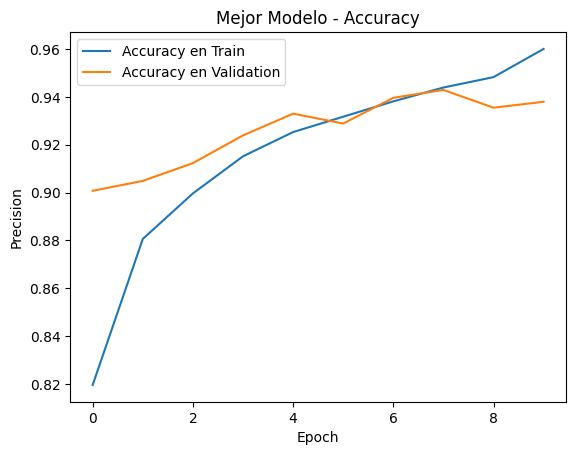

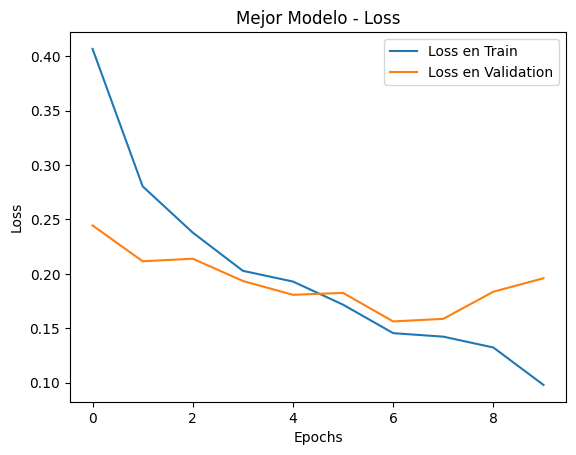

In [10]:
#22. Gráfico de accuracy
plt.plot(best_history.history['accuracy'], label='Accuracy en Train')
plt.plot(best_history.history['val_accuracy'], label='Accuracy en Validation')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Mejor Modelo - Accuracy')
plt.show()

#23. Gráfico de loss
plt.plot(best_history.history['loss'], label='Loss en Train')
plt.plot(best_history.history['val_loss'], label='Loss en Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Mejor Modelo - Loss')
plt.show()

## Adición de Data Augmentation

Con el fin de simular algunas de las posibles variaciones de luminosidad, posición y condiciones de la cámara de un celular, se decidió entrenar un segundo modelo utilizando la mejor configuración de hiperparámetros encontrada anteriormente, pero esta vez aplicando **Data Augmentation** y eliminando el callback de *early_stopping*. Lo anterior permitirá aumentar la cantidad de imagenes con alteraciones, lo cual debería ayudar al modelo a generalizar ante más condiciones.

Para este segundo modelo, se aplicaron las siguientes técnicas de Data Augmentation:

- **RandomZoom(0.2)**: Simula diferentes niveles de zoom, para que el modelo se adapte a variaciones en el tamaño de las caras o a imagenes tomadas desde diferentes distancias.
- **RandomBrightness(0.2)**: Ajuste aleatorio del brillo para reflejar diferentes condiciones de iluminación, como las que podrían encontrarse en ambientes interiores o exteriores.
- **RandomContrast(0.2)**: Variación en el contraste para mejorar simular situaciones con diferencias de iluminación.
- **RandomRotation(0.2)**: Rotación aleatoria de hasta 20 grados para simular inclinaciones de la cámara o movimientos de cabeza.

In [11]:
#24. Técnicas de data augmentation
data_augmentation = Sequential([
    layers.RandomZoom(0.2), # Zoom aleatorio
    layers.RandomBrightness(0.2), # Ajuste de brillo
    layers.RandomContrast(0.2), # Ajuste de contraste
    layers.RandomRotation(0.2), # Rotación aleatoria hasta 20°
])

In [12]:
#25. Crear el modelo para data augmentation utilizando la mejor configuración encontrada
modelo_2 = Sequential([
    
    # Capa de entrada
    layers.InputLayer(shape=(224, 224, 3)),
    
    # Adición del data augmentation
    data_augmentation,

    # Primera capa convolucional
    layers.Conv2D(best_hiper['filtros_cn1'], (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(best_hiper['dropout_1']),

    # Segunda capa convolucional
    layers.Conv2D(best_hiper['filtros_cn2'], (3, 3), activation='relu'),
    layers. MaxPooling2D((2, 2)),
    layers.Dropout(best_hiper['dropout_2']),

    # Tercera capa convolucional
    layers.Conv2D(best_hiper['filtros_cn3'], (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(best_hiper['dropout_3']),

    # Aplanado de la salida de las capas convolucionales
    layers.Flatten(),

    # Capa densa
    layers.Dense(best_hiper['d_units'], activation='relu'),
    layers.Dropout(best_hiper['dropout_4']),

    # Capa de salida
    layers.Dense(1, activation='sigmoid')
])

#26. Compilación del modelo
modelo_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#27. Entrenamiento del modelo con los mismos parámetros que el primero
history_2 = modelo_2.fit(X_train, y_train, validation_split=0.2, epochs=10, verbose=1)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 62s 396ms/step - accuracy: 0.5096 - loss: 3.6746 - val_accuracy: 0.4723 - val_loss: 0.6944
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 364ms/step - accuracy: 0.5135 - loss: 0.6931 - val_accuracy: 0.4723 - val_loss: 0.6945
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 361ms/step - accuracy: 0.5139 - loss: 0.6927 - val_accuracy: 0.4723 - val_loss: 0.6949
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 362ms/step - accuracy: 0.5118 - loss: 0.6930 - val_accuracy: 0.4723 - val_loss: 0.6945
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 363ms/step - accuracy: 0.5159 - loss: 0.6928 - val_accuracy: 0.4723 - val_loss: 0.6948
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 363ms/step - accuracy: 0.5040 - loss: 0.6932 - val_accuracy: 0.4723 - val_loss: 0.6953
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5157 - loss: 0.6927 - val_accuracy: 0.4723 - val_loss: 0.6948
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 55s 361ms/step - accuracy: 0.5162 - loss: 0

### Analisis de Modelo con Data Augmentation

Al analizar los resultados obtenidos por el modelo con Data Augmentation, se observó que el rendimiento no mejoró como se esperaba. Al contario, el modelo sin Data Augmentatión mostro mejores métricos. El modelo con esta técnica presentó un rendimiento de casi un 40% peor en accuracy en comparación con el modelo original. Lo anterior puede ser debido a lo siguiente:

* Es posible que al aplicar la técnica se introdujera una cantidad considerable de variabilidad en las imagenes de entrenamiento, la cual pudo haber sido muy agresiva generando, generando imagenes con características alejadas de las que realmente se encuentran en los otros dos conjuntos, provocando que el modelo se encuentre con un bias alto, es decir, underfitting. 

* Es posible que algunas de las transformaciones utilizadas no sean totalmente representativas de las clases en las que se decidió separar, por lo que el modelo pudo no haber encontrado características clave que le permitieran identificar una persona con mascarilla y sin mascarilla.

Por lo tanto, probando el modelo de data augmentation con la mejor configuración encontrada para el **modelo 1**, se obtuvo que la accuracy final es de **51%**.

In [13]:
#28. Accuracy en Test Set
test_loss2, test_acc2 = modelo_2.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy en el test set: {test_acc2:.2f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.4861 - loss: 0.6941
Accuracy en el test set: 0.51


# Resultados e Interpretación

### Comparación y Selección de Modelos

A lo largo de la sección 3, se probaron dos enfoques distintos para la creación de una red neuronal convolucional (CNN) para clasificar imagenes de personas con y sin mascarilla. Estos enfoques son la búsqueda de la mejor configuración de hiperparámetros para la arquitectura de la red y la implementación de técnicas de Data Augmentation para incrementar la diversidad del conjunto de entrenamiento.

### Mejor Configuración de Hiperparámetros - Modelo #1

Después de probar cuatro configuraciones específicas de hiperparámetros, se determinó que la combinación que optimizaba el balance entre accuracy y de generalización fue el siguiente:

- **Filtros en Capas Convolucionales (Conv2D):** 32, 64, 64, filtros ligeramente crecientes para capturar mejores características y patrones en las imagenes.
- **Unidades en Capa Densa:** 64
- **Tasas de Dropout:** 0.2, 0.2, 0.2, y 0.3 en cada capa convolucional y densa para reducir la probabilidad de overfitting.
- **Ventana de MaxPooling:** 2x2, para reducir la dimensionalidad mientras se mantienen las características más importantes.
- **Optimizador:** Adam, por su capacidad de convergencia rápida.
- **Función de Costo:** Binary Crossentropy, por el tipo de problema de clasificación binaria.
- **Callback:** Early Stopping con un patience de 3 epochs, debido al número relativamente bajo de epochs.

Esta configuración logró un **accuracy del 87%** en el conjunto de prueba. El uso de filtros de tamaño creciente en las capas convolucionales ayudó a capturar tanto características como patrones  en las imagenes. Además, el Dropout y el Early Stopping ayudaron a reducir el overfitting. Esta configuración fue seleccionada como base para comparar con el segundo enfoque de Data Augmentation.

### Resultados con Data Augmentation - Modelo #2

Con el objetivo de aumentar la robustez del modelo frente a variaciones comunes imagenes tomadas con cámaras de celular, como cambios en la iluminación, posición y distancia, se aplicaron técnicas de Data Augmentation sobre la mejor configuración de hiperparámetros encontrada. Las transformaciones utilizadas incluyen:

- **Random Zoom** para simular diferentes distancias entre la cámara y la persona
- **Random Brightness** para variar condiciones de iluminación
- **Random Contrast** para simular diferencias en iluminación
- **Random Rotation** para representar posibles movimientos o inclinaciones de la cabeza o celular

Sin embargo, el modelo entrenado con Data Augmentation mostró un rendimiento bajo, con un accuracy final del **51%** en el conjunto de prueba, lo cual es considerablemente peor que el modelo sin Data Augmentation. Esta reducción de rendimiento puede explicarse por las siguientes razones:

1. **Variabilidad:** Las transformaciones pudieron haber introducido variaciones que alejan demasiado las imagenes augmentadas de las imagenes del conjunto de validación y prueba, haciendo que el modelo no pueda encontrar patrones relevantes en las características principales de cada clase.

2. **Contexto Real:** Algunas de las transformaciones aplicadas (por ejemplo, rotaciones y ajustes de contraste extremos) no representan la mayoría de las condiciones reales en las que podría salir una imagen.

3. **Bias Alto (Underfitting):** La gran variabilidad de las imagenes augmentadas pudo haber llevado al modelo a tener dificultades para captar patrones relevantes, generando un modelo con underfitting.

## Probando el Modelo con Imágenes Nuevas

Predicción para la imagen sin mascarilla:


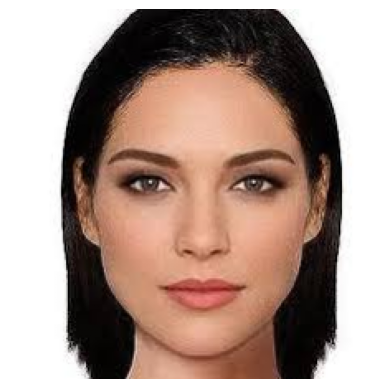

PREDICCIÓN: sin mascarilla

Predicción para la imagen con mascarilla:


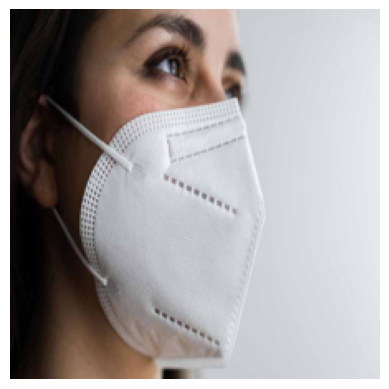

PREDICCIÓN: con mascarilla

Predicción para la imagen de Will Smith:


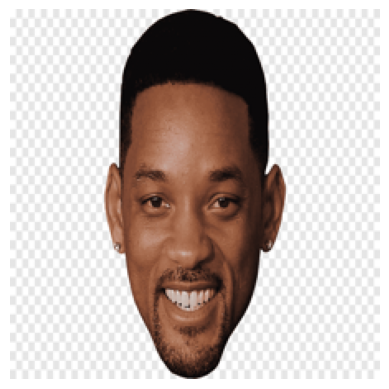

PREDICCIÓN: sin mascarilla



In [14]:
#29. Funcion para predecir con el mejor modelo e imprimir la nueva imagen 
# Parámetros: (path a imagen , modelo)
def predict_and_print(img_path, model):
    
     # Se normaliza con una funcion anteriormente creada
    img_array = resize_and_norm(img_path)
    
    # Muestra la imagen
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()
    
    # Añade una dimension para que funcione en el modelo
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realiza la predicción
    prediction = model.predict(img_array, verbose= 0)
    
    # ¿Tiene o no mascarilla? OJITO
    if prediction[0][0] >= 0.5:
        print("PREDICCIÓN: con mascarilla\n")
    else:
        print("PREDICCIÓN: sin mascarilla\n")

img_sin = 'sin.jpeg'
img_con = 'con.jpg'
img_will_sin = 'WILL.png'

print("Predicción para la imagen sin mascarilla:")
predict_and_print(img_sin, best_model)

print("Predicción para la imagen con mascarilla:")
predict_and_print(img_con, best_model)

print("Predicción para la imagen de Will Smith:")
predict_and_print(img_will_sin, best_model)


# Conclusión

En conclusión, en base a los resultados obtenidos, se decidió optar por el modelo sin Data Augmentation como el modelo final. Aunque Data Augmentation es una buena técnica para mejorar la capacidad de generalización, en este caso particular, su implementación no proporcionó los resultados esperados y disminuyó considerablemente el rendimiento del modelo. Por tanto, los parámetros ganadores son los siguientes:

* **Filtros en Capas Convolucionales (Conv2D):** 32, 64, 64, lo cual permitió capturar tanto características de bajo nivel como patrones más complejos en las imagenes.
* **Unidades en Capa Densa:** 64.
* **Tasas de Dropout:** 0.2, 0.2, 0.2, y 0.3, aplicadas después de cada capa convolucional y la capa densa para reducir la probabilidad de overfitting.
* **Ventana de MaxPooling:** 2x2, para reducir la dimensionalidad mientras se mantienen las características más importantes.
* **Optimizador:** Adam, por su capacidad de convergencia rápida.
* **Función de Costo:** Binary Crossentropy, la cual es estándar para problemas de clasificación binaria.
* **Callback:** Early Stopping con un patience de 3 epochs, debido al número relativamente bajo de epochs.

Los parámetros anteriores lograron un accuracy de 87%, mostrando que el modelo es el más eficiente y robusto para clasificar imagenes con personas con y sin mascarillas.

## Proyecto

Lo que más me gustó de este proyecto fue que pude aplicar una red neuronal convolucional a una problemática real que sucedió en 2020. La experiencia de desarrollar un modelo para cubrir una necesidad específica me resultó muy interesante. Sentí que estaba realizando una investigación al buscar la mejor configuración del modelo y probar técnicas como el Data Augmentation.

El principal reto que encontré fue trabajar con recursos computacionales limitados. Sin una GPU, el tiempo de entrenamiento y carga de trabajo fue considerablemente alto, lo que me obligó a tener cuidado en la cantidad de configuraciones que decidí probar, especialmente en el modelo con Data Augmentation. Otro desafío fue entender por qué el modelo que incluía Data Augmentation resultó en un peor rendimiento. Tras un analizarlo, comprendí que la técnica introdujo demasiada varianza en las imagenes, lo que terminó afectando ampliamente en su capacidad de generalizar.

En conclusión, considero que este proyecto me permitió profundizar en la creación de redes neuronales convolucionales en el contexto de Deep Learning y me ayudó a entender la importancia de probar varias configuraciones para optimizar tanto los métricos de rendimiento como la eficiencia del modelo para resolver un problema específico.

# Parte Creativa - Exportar el Modelo para uso en App

Para la parte creativa de este proyecto, decidí implementar una funcionalidad que permite analizar en tiempo real, a través de la cámara de la computadora, si una persona tiene o no puesta una mascarilla. El siguiente bloque de código permite realizar este análisis en tiempo real:

In [ ]:
import cv2

#30. Función para preprocesar el video (resizing y normalización)
# Parametros ( frame (captura de video) )
def preprocess_frame(frame):
    
    # Convertir la imagen de BGR a RGB
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Redimensionar la imagen al tamaño de entrada del modelo (224x224 en este caso)
    img = cv2.resize(img, (224, 224))
    
    # Normalizar la imagen a valores entre [0, 1]
    img = img / 255.0
    
    # Expandir dimensiones para que coincida con la entrada del modelo (batch size de 1)
    img = np.expand_dims(img, axis=0)
    
    return img

#31. Función para realizar la predicción con el modelo
# Parametros ( frame (captura de video) )
def predict_mask(frame):
    
    # Imagen
    input_data = preprocess_frame(frame)
    
    # Predecir con el modelo de la mejor configutación
    prediction = best_model.predict(input_data)[0][0]
    
    # Obtener resultado
    return "Con mascarilla" if prediction >= 0.5 else "Sin mascarilla"

#32. Empezar la captura de video
cap = cv2.VideoCapture(0)
while True:
    
    # Captura del frame de la cámara
    ret, frame = cap.read()
    if not ret:
        break
    
    # Realizar la predicción en tiempo real con el modelo
    label = predict_mask(frame)
    
    # Despliegue de Texto de Predicción + Caja para poder leerlo
    font = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX
    font_scale = 1.5
    font_thickness = 2
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

    # Posición de la caja y el texto en el frame
    text_x = 10
    text_y = 40
    box_coords = ((text_x - 50, text_y - 50), (text_x + text_size[0] + 10, text_y + text_size[1] + 10))

    # Background del texto
    cv2.rectangle(frame, box_coords[0], box_coords[1], (0, 0, 0), cv2.FILLED)
    
    # Texto
    cv2.putText(frame, label, (text_x, text_y), font, font_scale, (0, 255, 0), font_thickness)
    cv2.imshow("Detección de Mascarilla", frame)
    
    # Terminar la ejecución de la cámara con q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Terminar captura de video
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

: 

# Referencias

Gurav, O. (2020). *Face Mask Detection Dataset*. Kaggle. https://www.kaggle.com/datasets/omkargurav/face-mask-dataset?resource=download

Keras. (2024). *Adam*. Keras. https://keras.io/api/optimizers/adam/

Kraay, M. (2022). *Creating ML Models for SwiftUI with Tensorflow*. Kaggle. https://www.youtube.com/watch?v=L3dQ02uyoro

Tensorflow. (2024). _Data Autmentation_. Tensorflow. https://www.tensorflow.org/tutorials/images/data_augmentation